In [20]:
using PyPlot, ForwardDiff, TaylorSeries, LinearAlgebra, Roots
function rescale!(x::Taylor1,lambda)
    mult = one(lambda);
    for i in 2:length(x.coeffs)
        mult /= lambda
        x.coeffs[i] *= mult
    end
    x
end
ForwardDiff.can_dual(::Type{Taylor1{Float64}}) = true
Base.isinteger(::Taylor1{Float64}) = false

In [21]:
function sol(x,y) # well ok its not a solenoid any more
    1-1.4x^2 + y, 0.3x
end
sol(x) = [sol(x...)...]

function invsol(x,y)
    y/0.3, x-(1-1.4*(y/0.3)^2)
end
invsol(x) = [invsol(x...)...]

function Jsol(x,y)
    [-1.4*2x 1;0.3 0]
end
function Jinvsol(x,y)
    inv([-1.4*2(y/0.3) 1;0.3 0])
end


Jinvsol (generic function with 1 method)

In [29]:
t = Taylor1(Float64,2)
(xsol,ysol) = 0.2rand(2) .+ t
# vusol = randn(2)+dualnum*randn(2)
for i = 1:10000
    (xsol,ysol) = sol(xsol,ysol); lusol = hypot(xsol[1],ysol[1])
    rescale!(xsol,lusol); rescale!(ysol,lusol)
#     vusol = Jsol([xsol,ysol])*vusol; vusol /= norm(realpart.(vusol)) # to make make sense....
#     println(vusol)
end
N = 200_000
solh = Array{typeof(xsol)}(undef,N,2)
# vusolh = Array{Dual{Float64}}(undef,N,2)
lusolh = Array{Float64}(undef,N)
for i = 1:N
    (xsol,ysol) = sol(xsol,ysol); lusol = hypot(xsol[1],ysol[1])
    rescale!(xsol,lusol); rescale!(ysol,lusol)
    solh[i,1] = xsol; solh[i,2] = ysol
    lusolh[i] = lusol
end
dxdtnorm = sqrt.(differentiate.(solh[:,1]).^2 + differentiate.(solh[:,2]).^2)
rhograds = getindex.(1 ./dxdtnorm,1);

In [30]:
lsol = rand(2) .+ differentiate(t^2/2)
lsolh = Array{Taylor1{Float64}}(undef,N,2)
lsolh[N,:] = lsol
for i = N-1:-1:1
    lsol = Jsol(solh[i,1],solh[i,2])'*lsol; 
    lsol /= dot(differentiate.(solh[i,:])/dxdtnorm[i],lsol)
    lsolh[i,:] = lsol
    end
lnorms = vec(mapslices(x->norm(getcoeff.(x,0)),lsolh,dims=2))
dldt = getcoeff.(lsolh,1);

In [31]:
krhopart = rhograds.*getcoeff.(lsolh,0); krhonorms = abs.(rhograds) .* lnorms
kXnorms = lnorms;
klpart = dldt ./ getcoeff.(dxdtnorm,0); klnorms = vec(mapslices(norm,klpart,dims=2));

In [32]:
Xv = [ zeros(N) getcoeff.(solh[:,1],0)]
DXvxy = ones(N)
lrtdensity = vec(sum((krhopart + klpart).*Xv,dims=2) + 
    getcoeff.(lsolh[:,2],0).*(DXvxy.*getcoeff.(solh[:,1],1)./getcoeff.(dxdtnorm,0)));

In [33]:
function dotprods(x,y,fd=2,bw=1)
    Jfd = Matrix{promote_type(typeof(x),typeof(y))}(LinearAlgebra.I,2,2)
    xfd,yfd = x,y
    for i = 1:fd
        Jfd = Jsol(xfd,yfd)*Jfd
        xfd,yfd = sol(xfd,yfd)
    end
        Jbw = Matrix{promote_type(typeof(x),typeof(y))}(LinearAlgebra.I,2,2)
        xbw,ybw = x,y
    for i = 1:bw
#         bw = Jinvsol(xbw,ybw)*Jbw
        xbw,ybw = invsol(xbw,ybw)
        Jbw = Jsol(xbw,ybw)'*Jbw
    end
    effd = svd(Jfd); efbw = svd(Jbw)
#     println(effd.S,efbw.S)
    dt = 1-dot(effd.V[:,1],efbw.V[:,1])^2
#     imag(dt) > 1000eps(eltype(Jfd)) && error("Complex eigenvalues: $(effd.values) $(efbw.values)")
    

end

dotprods (generic function with 3 methods)

In [34]:
exes = 0.67:0.001:1.3; wyes = -0.05:0.001:0.05
dotprodmat = dotprods.(exes,wyes',2,2)
wyes_tang = wyes[[findmax(dotprodmat[i,:])[2] for i in eachindex(exes)]];

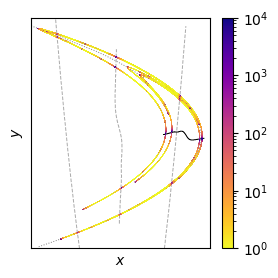

In [36]:
thecolormap = matplotlib.cm.get_cmap("summer")
figure(figsize=(2.88,2.88))
# imshow(log10.(1 .-dotprodmat'),extent=(extrema(exes)...,reverse(extrema(wyes))...)); #colorbar()
scatter(map.(solh[:,1],0),map.(solh[:,2],0),c=abs.(lrtdensity),marker=".",s=0.5,linewidth=0,
    norm=matplotlib.colors.LogNorm(vmin=1, vmax=1e4),cmap="plasma_r",zorder=3)
colorbar()
tangline0 = [exes wyes_tang]#(0.5:0.0003:1.5).*[1 0.0]
tangline = copy(tangline0)

for i = 1:2
    tangline = mapslices(sol,tangline,dims=2)
    plot(tangline[:,1], tangline[:,2],zorder=1,c="gray",":",linewidth=0.7)
end

tangline = copy(tangline0)
for i = 1:2
    tangline = mapslices(invsol,tangline,dims=2)
    plot(tangline[:,1], tangline[:,2],zorder=1,c="darkgray","--",linewidth=0.7)
end
plot(tangline0[:,1], tangline0[:,2],zorder=1,c="k",linewidth=0.7)

xlim(-1.4,1.4);ylim(-1.4*0.3,1.4*0.3)
xticks([]);yticks([])
xlabel("\$x\$");ylabel("\$y\$")
tight_layout()
savefig("../figures/Spaghetti-Henon.png",dpi=500)

In [24]:
plt.cmap("yolo")

KeyError: [91mKeyError: key :cmap not found[39m

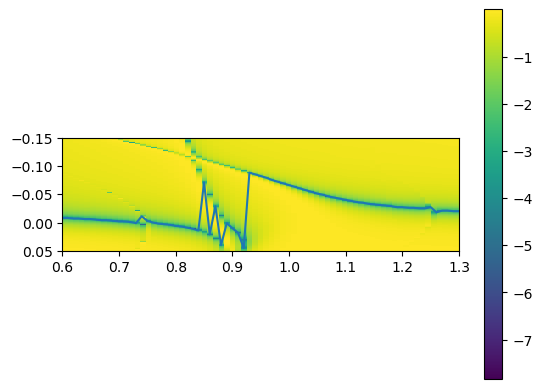

PyObject <matplotlib.colorbar.Colorbar object at 0x7f69cbf19cd0>

In [368]:
imshow(log10.(1 .-dotprodmat'),extent=(extrema(exes)...,reverse(extrema(wyes))...)); #colorbar()
plot(exes,wyes_tang)
gca().set_aspect("equal"); colorbar()

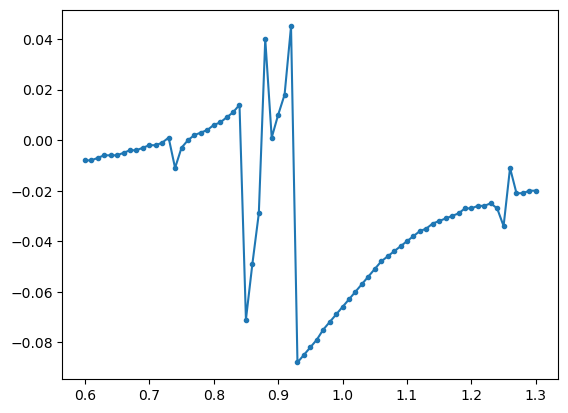

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f69cbbc8370>

In [334]:
plot(exes,wyes_tang,".-")

In [180]:
eigen([1 2; 3 4])

Eigen{Float64,Float64,Array{Float64,2},Array{Float64,1}}
values:
2-element Array{Float64,1}:
 -0.3722813232690143
  5.372281323269014
vectors:
2×2 Array{Float64,2}:
 -0.824565  -0.415974
  0.565767  -0.909377

In [152]:
]add Roots

   Updating registry at `~/.julia/registries/General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


    Fetching:

    Fetching: [==================>                      

    Fetching: [

Fetching: [========================================>]  100.0 %]  99.6 %

  Resolving package versions...
  Installed CommonSolve ────── v0.2.0
  Installed ConstructionBase ─ v1.3.0
  Installed Setfield ───────── v0.8.2
  Installed Roots ──────────── v2.0.1
   Updating `~/.julia/environments/v1.4/Project.toml`
  [f2b01f46] + Roots v2.0.1
   Updating `~/.julia/environments/v1.4/Manifest.toml`
  [38540f10] + CommonSolve v0.2.0
  [187b0558] + ConstructionBase v1.3.0
  [f2b01f46] + Roots v2.0.1
  [efcf1570] + Setfield v0.8.2
  [9fa8497b] + Future 
